In [1]:
# Load the TensorBoard notebook extension

#Uncomment to use it in colab and monitor to tendorboard
#%load_ext tensorboard

import tensorflow as tf
import datetime

##Data preparation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import kerastuner as kt
from contextlib import redirect_stdout
import shutil

Define the path to load all locally stored csv:

In [3]:
path = os.getcwd()+"/exper_files/datasets/" #Define where are the datasets from yahoo
social_path = os.getcwd()+"/exper_files/social_datasets/cryptocompare/" #Define where are the datasets from cryptocompare

In [4]:
def dataset_creation(crypto_list, pth, social_pth):
    datasets = {} #Store all datasets with market information here
    social_datasets = {} #Store all datasets with social media information here
    
    min_dates = {} #Store all minimum dates here
    max_dates = {} #Store all maximum dates here
    
    datasets_list = os.listdir(pth) #Find all dataset with market information
    social_datasets_list = os.listdir(social_pth) #Find all dataset with social media information
    
    crypto_list = [elem+'.csv' for elem in crypto_list]
    
    #Get market information for each coin from the corresponding csv
    for dataset in datasets_list:
        if dataset.endswith(".csv") and (dataset) in crypto_list:

            name = dataset.split(".")
            dataset_name = name[0]

            datasets[dataset_name] = pd.read_csv(pth + dataset) 

            datasets[dataset_name]['Date'] = pd.to_datetime(datasets[dataset_name]['Date'])
            datasets[dataset_name].fillna(method='ffill', inplace=True)

            #Create new columns 'close_off_high' and 'volatility' in order to make predictions more accurate:
            kwards = {'close_off_high': lambda x: 2 * (x['High'] - x['Close']) / (x['High'] - x['Low']) - 1,
              'volatility': lambda x: (x['High'] - x['Low']) / (x['Open'])
              }

            datasets[dataset_name] = datasets[dataset_name].assign(**kwards)
            
            datasets[dataset_name].fillna(-1, inplace=True) #Fill possible NaN close_off_high values with -1
                                                            #Because NaN values caused by (0/0)-1
            

            first_date = pd.to_datetime(datasets[dataset_name]['Date'][0])
            min_dates[dataset_name]=first_date
            
            last_date = pd.to_datetime(datasets[dataset_name]['Date'].iloc[-1])
            max_dates[dataset_name] = last_date
    
    
    #Get social media information for each coin from the corresponding csv
    for dataset in social_datasets_list:
        if dataset.endswith(".csv") and (dataset) in crypto_list:
            
            name = dataset.split(".")
            dataset_name = name[0]

            social_datasets[dataset_name] = pd.read_csv(social_pth + dataset) 
            
            social_datasets[dataset_name]['time'] = pd.to_datetime(social_datasets[dataset_name]['time'])
            
            #Drop first column which is an unused index
            social_datasets[dataset_name] = social_datasets[dataset_name].iloc[:, 1:]
            
            #We observed that there are many zero rows at social media datasets.
            #We should find the first row which is non-zero
            res = [next(((j, i) for i, j in enumerate(social_datasets[dataset_name][col]) if j != 0), (0, 0)) 
                   for col in social_datasets[dataset_name] if col != 'time']
            
            #Get all columns except 'time'
            columns_except_time = [col for col in social_datasets[dataset_name].columns if col != 'time']
            
            #Store the index of each column with the first non-zero element
            df_res = pd.DataFrame(res, columns=['value', 'position'], index=columns_except_time)
            
            #Get the minimum of these indices
            first_non_zero_row = df_res['position'].min()

            
            first_date = pd.to_datetime(social_datasets[dataset_name]['time'][first_non_zero_row])
            if first_date >  min_dates[dataset_name]:
                 min_dates[dataset_name] = first_date
                    
            last_date = pd.to_datetime(social_datasets[dataset_name]['time'].iloc[-1])
            if last_date < max_dates[dataset_name]:
                max_dates[dataset_name] = last_date
            

    max_date = max(min_dates.values(), key=lambda v: v)
    min_date = min(max_dates.values(), key=lambda v: v)
    

    #Drop all the data which are prior to max_date and later to min_date
    for dataset in datasets:
        datasets[dataset] = datasets[dataset][(datasets[dataset]['Date'] >= max_date) & 
                                              (datasets[dataset]['Date'] <= min_date)]
        
    for dataset in social_datasets:
        social_datasets[dataset] = social_datasets[dataset][(social_datasets[dataset]['time'] >= max_date) & 
                                                            (social_datasets[dataset]['time'] <= min_date)]

    
    #Compute the average and standard deviation of 'Close' value for the last 7-days and 30-days(month): 
    for dataset in datasets:

        temp = datasets[dataset].copy()

        #Drop the first 30 days to be able to compute average and standard deviation of month for the rows of the table
        temp = temp[29:]

        temp['mean_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).mean()

        temp['mean_month_Close'] = datasets[dataset]['Close'].rolling(window=30).mean()

        temp['std_7days_Close'] = datasets[dataset]['Close'].rolling(window=7).std()

        temp['std_month_Close'] = datasets[dataset]['Close'].rolling(window=30).std()

        datasets[dataset] = temp.copy()
        
    
    #Drop the first 30 days of 'social_datasets' to be aligned with 'datasets'
    for dataset in social_datasets:
            social_datasets[dataset] = social_datasets[dataset][29:]
        
        



    #Rename the columns
    count = 0
    for dataset in datasets:

        datasets[dataset] = datasets[dataset].rename(columns={'Close':dataset+'_Close', 'Open':dataset+'_Open', 
                                                              'High':dataset+'_High', 'Low':dataset+'_Low', 
                                                              'Adj Close':dataset+'_Adj_Close', 
                                                              'Volume':dataset+'_Volume', 
                                                              'close_off_high':dataset+'_close_off_high',
                                                              'volatility':dataset+'_volatility',
                                                              'mean_7days_Close':dataset+'_mean_7days_Close',
                                                              'mean_month_Close':dataset+'_mean_month_Close',
                                                              'std_7days_Close':dataset+'_std_7days_Close',
                                                              'std_month_Close':dataset+'_std_month_Close'})
        
        
        if count == 0:
            
            date_col = (datasets[dataset]['Date'].reset_index()).drop(['index'], axis=1)
            
            
        datasets[dataset] = ((datasets[dataset].drop(['Date'], axis=1)).reset_index()).drop(['index'], axis=1) 
        
    
    
    for dataset in social_datasets:
        
        social_datasets[dataset] = social_datasets[dataset].rename(columns=lambda x: dataset+'_'+x)
        
        social_datasets[dataset] = ((social_datasets[dataset].drop([dataset+'_time'], axis=1)).reset_index()).drop(['index'], 
                                                                                                          axis=1) 
                                                            
    
    
    #Concatenate all datasets to one 
    whole_market_dataset = pd.concat([datasets[dataset] for dataset in datasets], axis=1)
    whole_social_dataset = pd.concat([social_datasets[dataset] for dataset in social_datasets], axis=1)
    whole_dataset = pd.concat([date_col, whole_market_dataset, whole_social_dataset], axis=1)
    
   
    return whole_dataset

Split data into training, validation and test set:

In [5]:
def split_data(perc_train_set, perc_val_set, currency_data):
        
        #Compute the date to split the dataset into training and validation_test set based on 'perc_train_set'
        splt_date_train = currency_data.iloc[round(currency_data.shape[0] * perc_train_set)]['Date']
        
        #Split the dataset into trainning and validation_test set
        tr_set, val_tst_set = currency_data[currency_data['Date'] < splt_date_train], \
                         currency_data[currency_data['Date'] >= splt_date_train]
        
        #Compute the date to split the val_tst_set into validation and test set based on 'perc_val_set'
        splt_date_val = val_tst_set.iloc[round(val_tst_set.shape[0] * perc_val_set)]['Date']

        #Split the val_tst_set into validation and test set        
        val_set, tst_set = val_tst_set[val_tst_set['Date'] < splt_date_val], \
                            val_tst_set[val_tst_set['Date'] >= splt_date_val]
        
        return tr_set, val_set, tst_set, splt_date_train, splt_date_val

Normalize training, validation and test inputs and outputs with sliding window:

In [6]:
def normalize_in_out(prd_range, wind_len, tr_set, val_set, tst_set, feats, coin_targ, crypto_list):
    
    all_feats = tr_set.columns #Get all features
    feats = [crypto+"_"+feat for crypto in crypto_list for feat in feats] #Get the features in the appropriate format 
                                                                          #(e.g 'Close' --> 'BTC-USD_Close')
    
    #Normalize training inputs
    LSTM_tr_in = []
    for i in range(len(tr_set) - wind_len):
        tmp_set = tr_set[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used

        LSTM_tr_in.append(tmp_set)
    
    #Transform from DataFrame to numpy array
    LSTM_tr_in = [np.array(LSTM_tr_i) for LSTM_tr_i in LSTM_tr_in]
    LSTM_tr_in = np.array(LSTM_tr_in)
    
    
    #Normalize validation inputs
    LSTM_val_in = []
    for i in range(len(val_set) - wind_len):
        tmp_set = val_set[i:(i + wind_len)].copy()
        
        for col in all_feats:
            if col not in feats:
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used
    
        LSTM_val_in.append(tmp_set)
        
    #Transform from DataFrame to numpy array
    LSTM_val_in = [np.array(LSTM_val_i) for LSTM_val_i in LSTM_val_in]
    LSTM_val_in = np.array(LSTM_val_in)
    
    
    #Normalize test inputs
    LSTM_test_in = []
    for i in range(len(tst_set) - wind_len):
        tmp_set = tst_set[i:(i + wind_len)].copy() 
        
        for col in all_feats:
            if col not in feats:
                
                tmp_set = tmp_set.drop([col], axis=1) #Drop the feature that will not be used

        for col in feats:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used

        LSTM_test_in.append(tmp_set)
    
    
    #Transform from DataFrame to numpy array
    LSTM_test_in = [np.array(LSTM_test_i) for LSTM_test_i in LSTM_test_in]
    LSTM_test_in = np.array(LSTM_test_in)
    
    
    #Normalize training outputs
    LSTM_rangd_train_out = []
    for i in range(wind_len, len(tr_set[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_train_out.append((tr_set[coin_targ+'_Close'][i:i+prd_range].values/tr_set[coin_targ+'_Close'][tr_set.index[0]+i-wind_len]) - 1)

    LSTM_rangd_train_out = np.array(LSTM_rangd_train_out)
    
    
    #Normalize validation outputs
    LSTM_rangd_val_out = []
    for i in range(wind_len, len(val_set[coin_targ+'_Close']) - prd_range):
        LSTM_rangd_val_out.append((val_set[coin_targ+'_Close'][i:i+prd_range].values/val_set[coin_targ+'_Close'][val_set.index[0]+i-wind_len]) - 1)
    
    LSTM_rangd_val_out = np.array(LSTM_rangd_val_out)
    
    return LSTM_rangd_train_out, LSTM_rangd_val_out, LSTM_tr_in, LSTM_val_in, LSTM_test_in

Plot correlation matrix and examine which are the best features:

Using cryptocurrencies: ['BTC-USD']


Without normalization


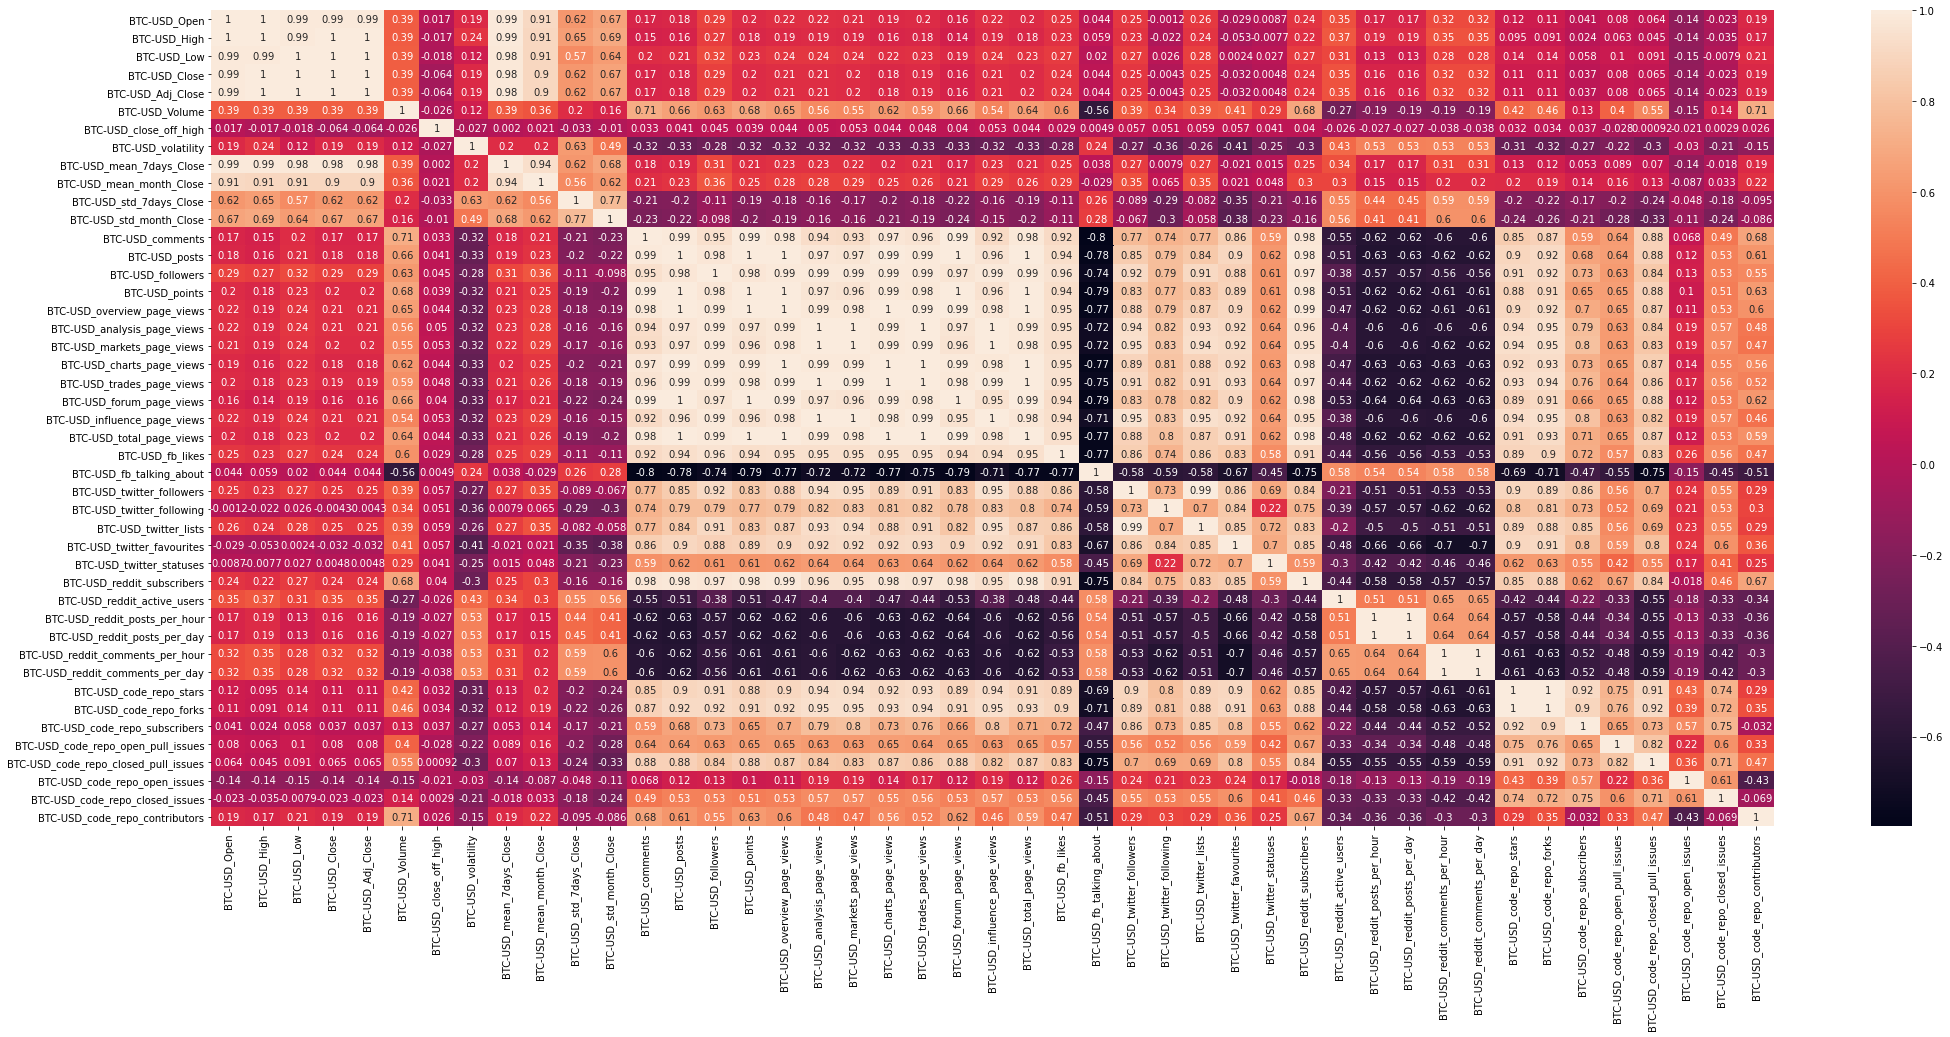

<ipython-input-108-e1a89dbd04e4>:15: RuntimeWarning: divide by zero encountered in log10
  scores = -np.log10(selector.pvalues_)


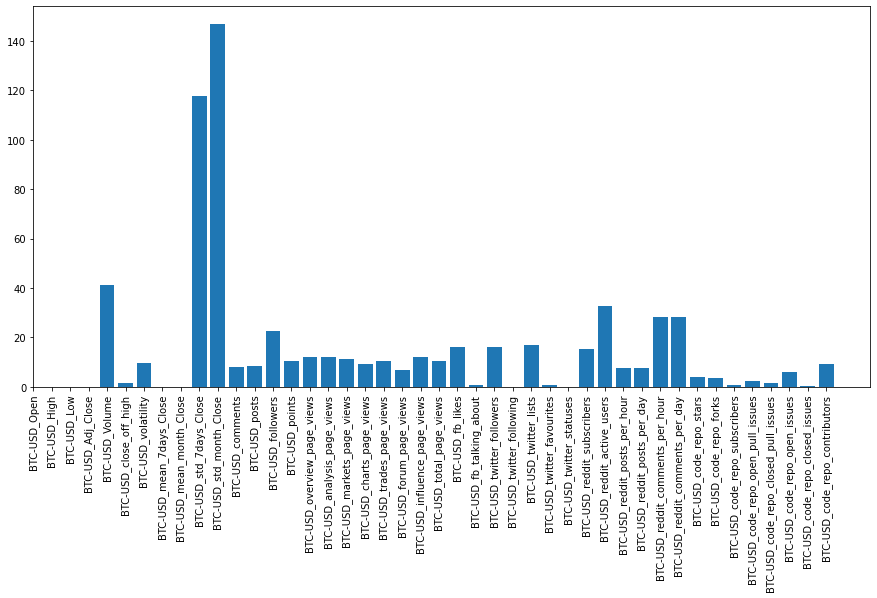

                            Feature_Name         Score
3                      BTC-USD_Adj_Close  1.684346e+18
1                           BTC-USD_High  1.426853e+05
2                            BTC-USD_Low  1.138598e+05
0                           BTC-USD_Open  5.951659e+04
7               BTC-USD_mean_7days_Close  3.119418e+04
8               BTC-USD_mean_month_Close  4.931590e+03
10               BTC-USD_std_month_Close  9.139615e+02
9                BTC-USD_std_7days_Close  6.846654e+02
4                         BTC-USD_Volume  2.007190e+02
31           BTC-USD_reddit_active_users  1.542505e+02
34      BTC-USD_reddit_comments_per_hour  1.316458e+02
35       BTC-USD_reddit_comments_per_day  1.316458e+02
13                     BTC-USD_followers  1.034961e+02
27                 BTC-USD_twitter_lists  7.625326e+01
25             BTC-USD_twitter_followers  7.183862e+01
23                      BTC-USD_fb_likes  7.071510e+01
30            BTC-USD_reddit_subscribers  6.708853e+01
21        

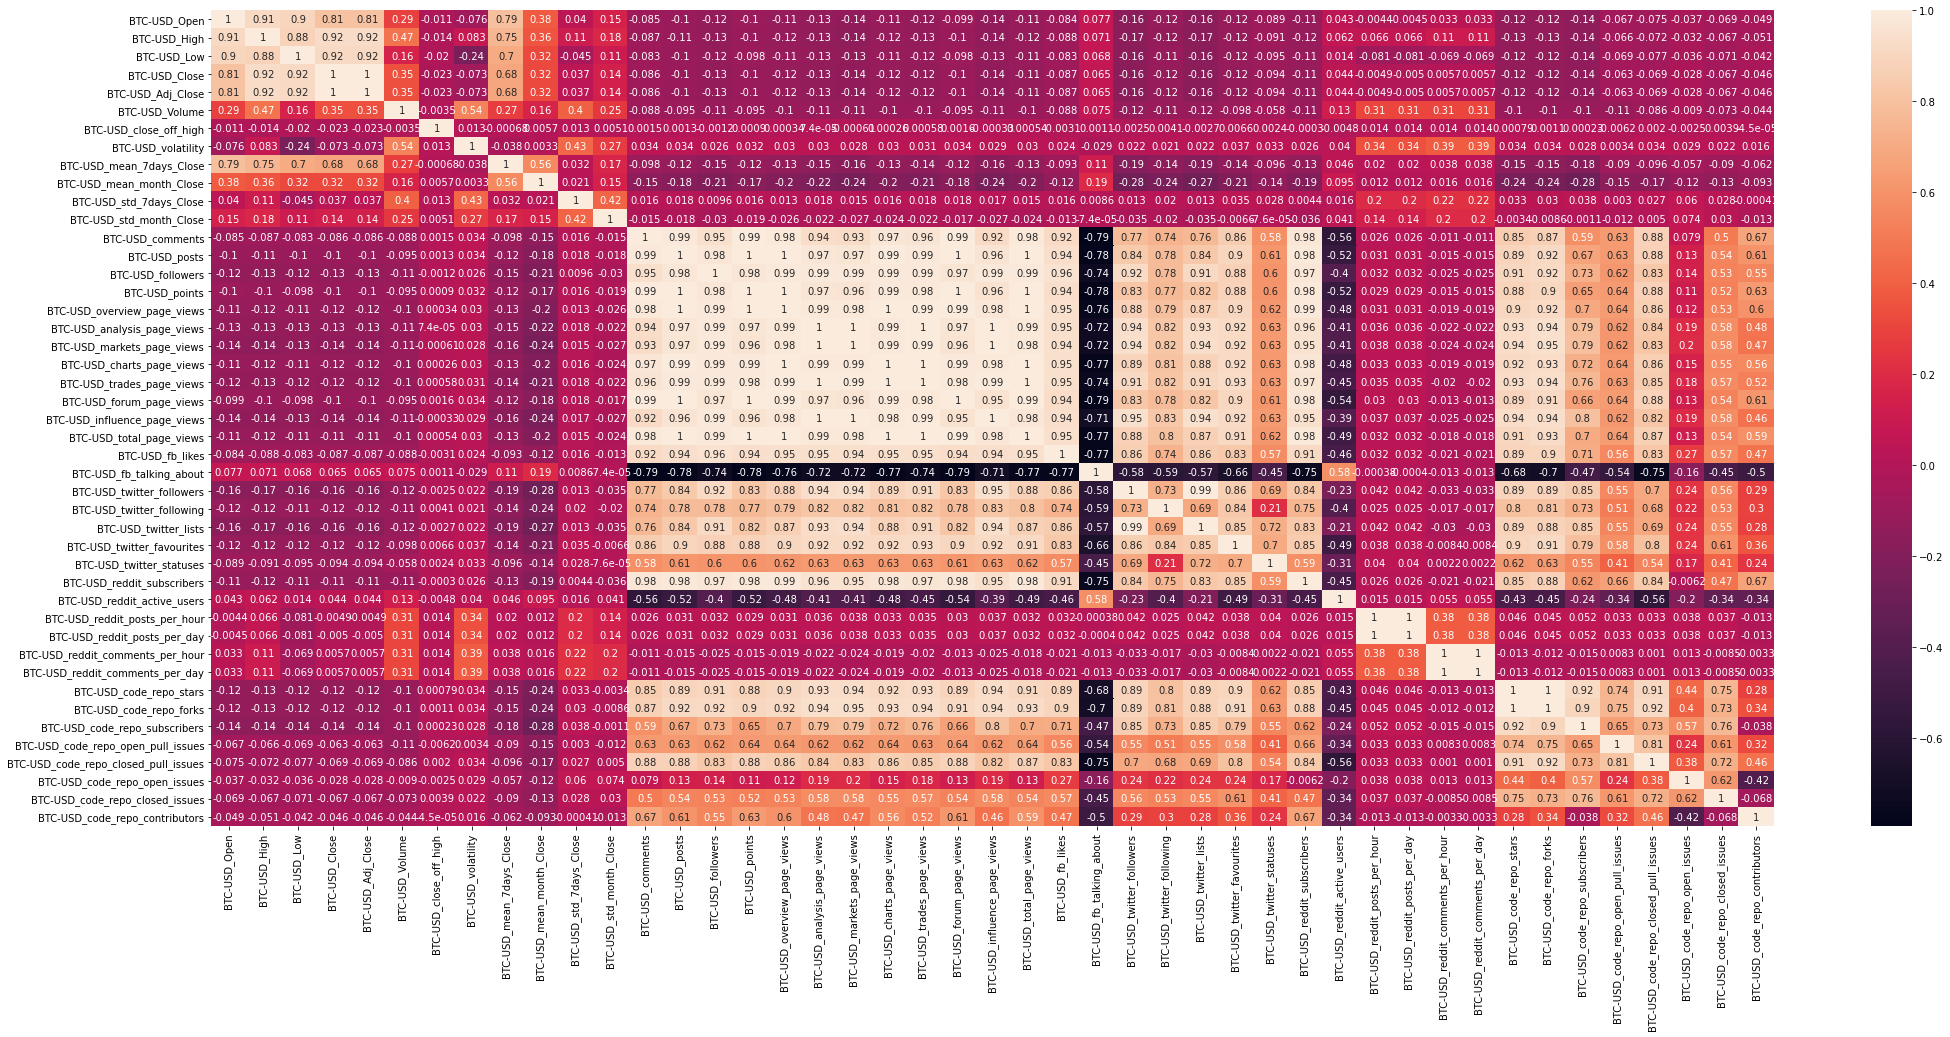

<ipython-input-108-e1a89dbd04e4>:15: RuntimeWarning: divide by zero encountered in log10
  scores = -np.log10(selector.pvalues_)


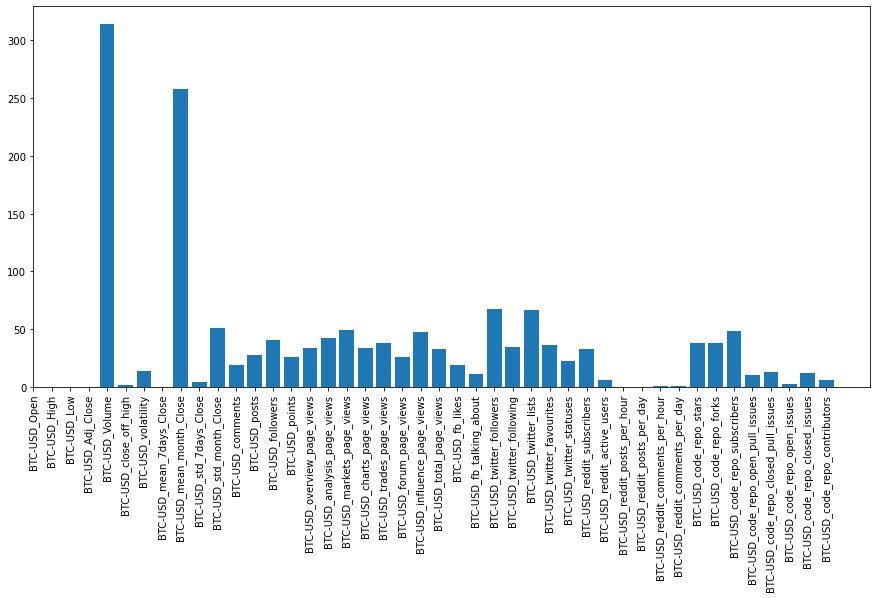

                            Feature_Name         Score
3                      BTC-USD_Adj_Close  1.618100e+18
1                           BTC-USD_High  6.520199e+04
2                            BTC-USD_Low  5.739778e+04
0                           BTC-USD_Open  2.087374e+04
7               BTC-USD_mean_7days_Close  9.689002e+03
4                         BTC-USD_Volume  1.534564e+03
8               BTC-USD_mean_month_Close  1.246334e+03
25             BTC-USD_twitter_followers  3.094355e+02
27                 BTC-USD_twitter_lists  3.054255e+02
10               BTC-USD_std_month_Close  2.298435e+02
17            BTC-USD_markets_page_views  2.223665e+02
38         BTC-USD_code_repo_subscribers  2.190157e+02
21          BTC-USD_influence_page_views  2.139549e+02
16           BTC-USD_analysis_page_views  1.910136e+02
13                     BTC-USD_followers  1.829785e+02
19             BTC-USD_trades_page_views  1.717511e+02
36               BTC-USD_code_repo_stars  1.699240e+02
37        

In [108]:
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

def plot_corr_matrix(datast):
    corrMatrix = datast.corr()
    plt.figure(figsize=(35,15))
    sns.heatmap(corrMatrix, annot=True)
    plt.show()
    
def select_best_feats(x_corr_matr, y_corr_matr):
    selector = SelectKBest(f_regression, k='all')
    fit = selector.fit(x_corr_matr, y_corr_matr)
    
    # Get the raw p-values for each feature, and transform from p-values into scores
    scores = -np.log10(selector.pvalues_)
    
    # Plot the scores. 
    predictors = x_corr_matrix.columns
    plt.figure(figsize=(15,7))
    plt.bar(range(len(predictors)), scores)
    plt.xticks(range(len(predictors)), predictors, rotation='vertical')
    plt.show()
    
    #Create a Data Frame with the scores of features
    df_scores = pd.DataFrame(fit.scores_)
    
    #Create a Data Frame with the names of features
    df_columns = pd.DataFrame(predictors) 
    
    #Concatenate the two above Data Frames to get in one column the names of features and in other their scores
    feature_scores = pd.concat([df_columns, df_scores],axis=1)

    #Specify column names
    feature_scores.columns = ['Feature_Name','Score'] 
    print(feature_scores.nlargest(45,'Score'))

    
def normalize_data(tr_set, wind_len):
    
    #Normalize training inputs
    count = 0
    for i in range(len(tr_set) - wind_len):
        tmp_set = tr_set[i:(i + wind_len)].copy()
        
        for col in tr_set.columns:
            tmp_set[:][col] = tmp_set[col] / tmp_set[col].iloc[0] - 1 #Normalize the feature that will be used
        
        if count == 0:
            
            tr_in = tmp_set.copy()
            count += 1
        
        else:
            
            tr_in = pd.concat([tr_in.copy(), tmp_set.copy()], ignore_index=True)

    return tr_in
    
#Get data
crypto_list = [['BTC-USD']] #Define the sets of cryptocurrencies to be tested

coin_target = 'BTC-USD'


for cryptocurrency_list in crypto_list:
    
    cryptocurrency_list_output = 'Using cryptocurrencies: '+str(cryptocurrency_list)
    print(cryptocurrency_list_output)
    data = dataset_creation(cryptocurrency_list, path, social_path)
    
    #Split data
    percent_train_set = 0.8
    percent_val_set = 0.5

    training_set, validation_set, test_set, split_date_train, split_date_valid = split_data(percent_train_set, 
                                                                                           percent_val_set, data)
    
    
    #####Without normalization###
    print('\n\n\033[1mWithout normalization\033[0m')
    
    #Plot correlation matrix 
    initial_corr_matrix_data = training_set.drop(['Date'], axis=1)
    corr_matrix_data = initial_corr_matrix_data.copy()
    plot_corr_matrix(corr_matrix_data)
    
    #Select best features using SelectKBest method with f_regression
    y_corr_matrix = corr_matrix_data.pop(coin_target+'_Close') 
    x_corr_matrix = corr_matrix_data.copy()
    select_best_feats(x_corr_matrix, y_corr_matrix)
    
    
    ###With normalization####
    
    print('\n\n\033[1mWith normalization\033[0m')
    
    window_len = 10
    norm_corr_matrix_data = normalize_data(initial_corr_matrix_data, window_len) #Normalize in sliding windows
    
    #Plot correlation matrix 
    plot_corr_matrix(norm_corr_matrix_data)
    
    
    #Select best features using SelectKBest method with f_regression
    norm_y_corr_matrix = norm_corr_matrix_data.pop(coin_target+'_Close') 
    norm_x_corr_matrix = norm_corr_matrix_data.copy()
    select_best_feats(norm_x_corr_matrix, norm_y_corr_matrix)
    

As we can observe the score of some features at the barplot are zero. For the first of them (BTC-USD_Open, BTC-USD_Low, BTC-USD_High, BTC-USD_mean_7days_Close, BTC-USD_mean_month_Close), it happens because their *p-value*  is too much close to 0, thus -log10 returns an *Infinite* value.
A low *p-value* means that we can reject null hypothesis. In *f_regression* method the null hypothesis of test performed is that all of the regression coefficients are equal to zero, which means that the model has no predictive capability. The variables which have 0 or almost 0 *p-value* should be considered that they are very effective predictors.

Next, it is significant to observe that correlation matrix and SelextKBest results are different for normazided and non-normalized data. This discrepancy should be taken into consideration on feature selection. We should choose the features based on results of normalized data, otherwise we will be biased due to numeric scale of each feature.

As we have already found out that 'Open' and 'High' lead to the best results in terms of the *market features*, now we will try the best *social media features*. We will begin with the 5 first of them. When a feature will have a correlation greater than 0.9 in relation with the rest of already chosen ones, it will be skipped.

The first is 'twitter_followers', next is 'twitter_lists', but they are extreme correlated (0.99), thus we will skip 'twitter_lists'.

Next in the list is 'market_page_views', which is also extreme correlated (0.94) with 'twitter_followers'. 

'code_repo_subscibers' has a correlation of grade 0.85 with 'twitter_followers' so we can include it.

'influence_page_view', 'analysis_page_views', 'followers' and 'trade_page_views' are correlated with 'twitter_followers' (0.95, 0.94, 0.92 and 0.91 respectively), then they will be excluded.

'code_repo_stars' and 'code_repo_forks' are correlated with 'code_repo_subscibers' (0.92 and 0.9, respectively), then they will be skipped.

'twitter_favourites' will be used as it has correlation values lower than 0.9 with the rest of the selected features.

Also, 'twitter_following' is suitable based on its correlation values with 'twitter_followers', 'code_repo_subscibers', 'twitter_favourites'.

'overview_page_views' and 'charts_page_views' are high correlated with 'twitter_favourites' (0.9  and 0.92, respectively), thus they will not be included.

'reddit_subscribers' is not overcome the correlation threshold of 0.9, so we should use it.

Finally, we have the 5 most informative social media features ('twitter_followers', 'code_repo_subscribers', 'twitter_favourites', 'twitter_following', 'reddit_subscribers')







Define and build model: 

In [17]:
########Model with CNN layers, followed by LSTM layers, followed by Dense layers #####################
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import AveragePooling1D
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf


def model_tuning(inputs, outputs, output_size, validation_inputs, validation_outputs, epochs, early_stop_patience, 
                 neurons, dropout, prd_range, batch_size, keras_tuner_dir, activ_func="linear", loss="mae", 
                 optimizer="adam"):
    
    def build_model(hp):
        model = Sequential()
        
        #filters_conv1 = hp.Choice('filters_Conv1', values=[16, 32, 64])
        #kernel_size_conv1 = hp.Choice('kernel_size_Conv1', values=[2, 3, 5])
        #strides_conv1 = hp.Choice('strides_Conv1', values=[1, 2, 3])
        #model.add(Conv1D(filters=filters_conv1, kernel_size=kernel_size_conv1, strides=strides_conv1, 
         #                activation='relu',
          #               input_shape=(inputs.shape[1], inputs.shape[2])))
        
        
        #moment_batchNormConv1 = hp.Float('momentum_batchNormConv1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormConv1))
        
        #pool_size_maxPool1 = hp.Choice('pool_size_MaxPool1', values=[2, 3, 4])
        #model.add(MaxPool1D(pool_size=2))
        #model.add(AveragePooling1D(pool_size=2))

        neurLSTM1 = hp.Choice('neurons_1_LSTM', values=neurons)
        model.add(LSTM(neurLSTM1, input_shape=(inputs.shape[1], inputs.shape[2]))) #return_sequences=True

        #dropLSTM1 = hp.Choice('dropout_LSTM_1', values=dropout)
        #model.add(Dropout(dropLSTM1))
        
        #neurLSTM2 = hp.Choice('neurons_2_LSTM', values=neurons)
        #model.add(LSTM(neurLSTM2))
        
        #dropLSTM2 = hp.Choice('dropout_LSTM_2', values=dropout)
        #model.add(Dropout(dropLSTM2))
        
        #moment_batchNormLSTM2 = hp.Float('momentum_batchNormLSTM2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormLSTM2))

        neurD1 = hp.Choice('neurons_1_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD1, activation='relu'))
        
        #dropDense1 = hp.Choice('dropout_Dense_1', values=dropout)
        #model.add(Dropout(dropDense1))
        
        #moment_batchNormDense1 = hp.Float('momentum_batchNormDense1', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense1))
        
        neurD2 = hp.Choice('neurons_2_Dense', values=[32, 64, 128, 256])
        model.add(Dense(units=neurD2, activation='relu'))
        
        #dropDense2 = hp.Choice('dropout_Dense_2', values=dropout)
        #model.add(Dropout(dropDense2))
        
        #moment_batchNormDense2 = hp.Float('momentum_batchNormDense2', min_value=0.09, max_value=0.99, step=0.1)
        #model.add(BatchNormalization(momentum=moment_batchNormDense2))
        
        model.add(Dense(units=output_size))
        model.add(Activation(activ_func))
        
        hp_learning_rate = hp.Float(name='learning_rate', min_value=0.0001, max_value=0.05, step=0.0005)
        
        hp_beta_1 = hp.Float('beta_1', min_value=0.85, max_value=0.95, step=0.01)
        
        hp_beta_2 = hp.Float('beta_2', min_value=0.98, max_value=0.999, step=0.001)
        
        hp_epsilon = hp.Float('epsilon', min_value=1e-07, max_value=1e-08, sampling='LOG')
        
        optimizer = tf.keras.optimizers.Adam(
        learning_rate=hp_learning_rate, beta_1=hp_beta_1, beta_2=hp_beta_2, epsilon=hp_epsilon)
        
        model.compile(loss=loss, optimizer=optimizer)
        return model
    
    
    
    #Create_tuner
    tuner = kt.Hyperband(build_model,
                 objective='val_loss',
                 max_epochs=epochs,
                 factor=3,
                 directory=keras_tuner_dir,
                 project_name='keras_tuner')

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience)

    tuner.search(inputs[:-prd_range], outputs, 
                 validation_data=(validation_inputs[:-prd_range], validation_outputs), 
                 epochs=epochs, batch_size=batch_size,callbacks=[stop_early],
                 use_multiprocessing=True,
                 workers=8)

    # Get the optimal hyperparameters
    best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

    
    return best_hps, tuner
    

Create MAE plot:

In [8]:
def create_plot(rangd_h, path_to_sav, target_cn):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(25, 10))

    ax1.plot(rangd_h.epoch, rangd_h.history['loss'], color='b', label='Loss')
    ax1.plot(rangd_h.epoch, rangd_h.history['val_loss'], color='orange', label='Val_loss')
    ax1.set_xticks(range(0, len(rangd_h.epoch)))
    ax1.set_title('Training Error')
    ax1.set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
    ax1.set_xlabel('#Epoch', fontsize=12)
    #plt.legend()
    plt.savefig(path_to_sav+"/"+target_cn+'_MAE.png')
    plt.close(fig)
    #plt.show()

Tune it and train it:

In [21]:
#Get data
crypto_list = [['BTC-USD']]#, 'ETH-USD']] #Define the sets of cryptocurrencies to be tested

first_txt_flag = 0


for cryptocurrency_list in crypto_list:
    
    cryptocurrency_list_output = 'Using cryptocurrencies: '+str(cryptocurrency_list)
    print(cryptocurrency_list_output)
    data = dataset_creation(cryptocurrency_list, path, social_path)
    
    #Split data
    percent_train_set = 0.8
    percent_val_set = 0.5

    training_set, validation_set, test_set, split_date_train, split_date_valid = split_data(percent_train_set, 
                                                                                           percent_val_set, data)

    features_list = [['Close', 'Open', 'High', 'twitter_followers', 'code_repo_subscribers','twitter_favourites', 
                      'twitter_following', 'reddit_subscribers']]
    
    """[['Close', 'Open', 'High', 'comments', 'posts', 'followers', 'points', 'overview_page_views',
                      'analysis_page_views', 'markets_page_views', 'charts_page_views', 'trades_page_views', 
                       'forum_page_views', 'influence_page_views', 'total_page_views', 'fb_likes', 'fb_talking_about',
                      'twitter_followers', 'twitter_following', 'twitter_lists', 'twitter_favourites', 
                       'twitter_statuses', 'reddit_subscribers', 'reddit_active_users', 'reddit_posts_per_hour',
                      'reddit_posts_per_day', 'reddit_comments_per_hour', 'reddit_comments_per_day', 'code_repo_stars',
                      'code_repo_forks', 'code_repo_subscribers', 'code_repo_open_pull_issues', 
                       'code_repo_closed_pull_issues', 'code_repo_open_issues', 'code_repo_closed_issues', 
                       'code_repo_contributors']]"""
    """[['Close'], ['Close', 'Volume'], ['Close', 'Open', 'High'],
                     ['Close', 'close_off_high', 'volatility'],
                     ['Close', 'mean_7days_Close', 'mean_month_Close'],
                     ['Close', 'std_7days_Close', 'std_month_Close']]""" #Define the sets of features to be tested
    
    
    for featurs in features_list: 
        
        new_txt_flag = 0 
        
        featurs_output = '\tUsing the features: '+str(featurs)
        print('\tUsing the features: '+str(featurs))
        
        
        #Create inputs and outputs for the model training, validation and testing
        pred_range = 5
        window_len = 10
        features = featurs
        coin_target = 'BTC-USD'
               
        

        LSTM_ranged_training_outputs, LSTM_ranged_validation_outputs, LSTM_training_inputs, LSTM_validation_inputs, LSTM_test_inputs = normalize_in_out(
                                                                                                      pred_range, window_len, 
                                                                                                      training_set, 
                                                                                                      validation_set, 
                                                                                                      test_set, 
                                                                                                      features, coin_target,
                                                                                                      cryptocurrency_list)
        
        #Define parameters
        epochs = 500
        batch_size_list = [64] #[1, 32, 64]
        neuron_list = [20, 40, 60, 100]
        dropout_list = [0.0, 0.1, 0.2, 0.25, 0.3, 0.4]
        early_stop_patience = 10
        shuffle = True
        verbose = 0
        
        
        
        
        for bat_s in batch_size_list:

            
            #Build and train model
            
            batch_size = bat_s
            
            exper_params_output = '\t\tBatch_size: '+str(batch_size)
            print(exper_params_output)
           
            
            #Path to write log files
            cur_path = os.getcwd()+'/'
            
            str_features = str(featurs)[:50]
            log_dir = cur_path + "logs/fit/" + str(cryptocurrency_list) + '/' + str_features + '/' + 'Batch_size='+str(batch_size)
            if not os.path.exists(log_dir):
                os.makedirs(log_dir)
            
            #Path to save its checkpoints the keras_tuner because it raises an error when it is in the current working
            #directory or in a sub-folder
            keras_tuner_dir = 'C:\keras_tuner'
            if not os.path.exists(keras_tuner_dir):
                os.makedirs(keras_tuner_dir)
            
            best_hps, tuner = model_tuning(inputs=LSTM_training_inputs, outputs=LSTM_ranged_training_outputs,
                                output_size=pred_range, 
                                validation_inputs = LSTM_validation_inputs, 
                                validation_outputs = LSTM_ranged_validation_outputs,
                                epochs=epochs, early_stop_patience=early_stop_patience, neurons=neuron_list, 
                                dropout=dropout_list, prd_range=pred_range, batch_size=bat_s, 
                                           keras_tuner_dir=keras_tuner_dir)
        
            exper_outputs = "\t\tThe hyperparameter search is complete. The optimal parameter were found to be: \n" + \
                            str(tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values)
        
            
            
            # Build the model with the optimal hyperparameters and train it
            best_model = tuner.hypermodel.build(best_hps)
            mod_history = best_model.fit(LSTM_training_inputs[:-pred_range], LSTM_ranged_training_outputs, 
                                         validation_data=(LSTM_validation_inputs[:-pred_range], 
                                                          LSTM_ranged_validation_outputs), 
                                         epochs=epochs)
            
            #Get the epoch with the best validation loss
            val_loss_per_epoch = mod_history.history['val_loss']
            best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
            exper_outputs += '\n\n\t\tBest epoch: '+ str(best_epoch) + ' with validation loss: ' + str((min(val_loss_per_epoch)))
            
            #Print results to a .txt file
            if first_txt_flag == 0:
                
                if new_txt_flag == 0:
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str_features + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    first_txt_flag += 1
                    new_txt_flag += 1
            else:
                
                if new_txt_flag == 0:
                    
                    f.close() #Close previous txt file
                    
                    #Create a .txt file and write the results
                    txt_log_dir = "logs/fit/" + str(cryptocurrency_list) + '/' + str_features + '/'
                    f = open(txt_log_dir+"/"+coin_target+"_results.txt", "w")
                    f.write(cryptocurrency_list_output)
                    f.write("\n"+featurs_output)
                    
                    new_txt_flag += 1
                    
                
            
            f.write("\n"+exper_params_output)
            f.write("\n"+exper_outputs)
            
            f.write("\n\nFull keras tuner results: \n")
            with redirect_stdout(f): 
                tuner.results_summary()
            
            
            create_plot(mod_history, log_dir, coin_target)

f.close()


#Write best model summary to a txt file
with open(cur_path + 'logs/fit/modelsummary.txt', 'w') as f_sum:
    with redirect_stdout(f_sum):
        best_model.summary()
        

#Remove folder with is created by keras tuner
shutil.rmtree(keras_tuner_dir)

Trial 725 Complete [00h 00m 07s]
val_loss: 0.07843954116106033

Best val_loss So Far: 0.053238578140735626
Total elapsed time: 00h 42m 55s
INFO:tensorflow:Oracle triggered exit
Epoch 1/500
35/35 [==============================] - 2s 16ms/step - loss: 0.6859 - val_loss: 0.0861
Epoch 2/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1159 - val_loss: 0.0877
Epoch 3/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1191 - val_loss: 0.0854
Epoch 4/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1176 - val_loss: 0.0867
Epoch 5/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1182 - val_loss: 0.0835
Epoch 6/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1190 - val_loss: 0.0803
Epoch 7/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1200 - val_loss: 0.0967
Epoch 8/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1225 - val_loss: 0.0793
Epoch 9/500
35/35 [===========

35/35 [==============================] - 0s 4ms/step - loss: 0.1266 - val_loss: 0.0761
Epoch 82/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1249 - val_loss: 0.0804
Epoch 83/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1216 - val_loss: 0.1021
Epoch 84/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1266 - val_loss: 0.0793
Epoch 85/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1193 - val_loss: 0.0774
Epoch 86/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1232 - val_loss: 0.1046
Epoch 87/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1212 - val_loss: 0.0840
Epoch 88/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1225 - val_loss: 0.0853
Epoch 89/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1224 - val_loss: 0.0784
Epoch 90/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1256 - val_loss: 0.0866
Epoch 91/500


35/35 [==============================] - 0s 5ms/step - loss: 0.1171 - val_loss: 0.0799
Epoch 163/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1223 - val_loss: 0.0754
Epoch 164/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1201 - val_loss: 0.0770
Epoch 165/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1275 - val_loss: 0.0810
Epoch 166/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1204 - val_loss: 0.0769
Epoch 167/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1223 - val_loss: 0.0848
Epoch 168/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1213 - val_loss: 0.0795
Epoch 169/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1177 - val_loss: 0.0776
Epoch 170/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1226 - val_loss: 0.0869
Epoch 171/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1200 - val_loss: 0.0838
Epoc

35/35 [==============================] - 0s 4ms/step - loss: 0.1219 - val_loss: 0.0853
Epoch 244/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1194 - val_loss: 0.0753
Epoch 245/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1240 - val_loss: 0.0851
Epoch 246/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1227 - val_loss: 0.0751
Epoch 247/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1313 - val_loss: 0.0898
Epoch 248/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1192 - val_loss: 0.0807
Epoch 249/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1183 - val_loss: 0.0858
Epoch 250/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1232 - val_loss: 0.0777
Epoch 251/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1243 - val_loss: 0.0788
Epoch 252/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1128 - val_loss: 0.0767
Epoc

35/35 [==============================] - 0s 5ms/step - loss: 0.1221 - val_loss: 0.0796
Epoch 325/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1177 - val_loss: 0.0769
Epoch 326/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1200 - val_loss: 0.0816
Epoch 327/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1203 - val_loss: 0.0769
Epoch 328/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1236 - val_loss: 0.0906
Epoch 329/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1203 - val_loss: 0.0852
Epoch 330/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1172 - val_loss: 0.0781
Epoch 331/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1226 - val_loss: 0.0811
Epoch 332/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1200 - val_loss: 0.0798
Epoch 333/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1226 - val_loss: 0.0889
Epoc

35/35 [==============================] - 0s 5ms/step - loss: 0.1224 - val_loss: 0.0799
Epoch 406/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1189 - val_loss: 0.0965
Epoch 407/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1198 - val_loss: 0.0836
Epoch 408/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1233 - val_loss: 0.0756
Epoch 409/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1182 - val_loss: 0.0848
Epoch 410/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1194 - val_loss: 0.0953
Epoch 411/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1173 - val_loss: 0.0781
Epoch 412/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1225 - val_loss: 0.0906
Epoch 413/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1183 - val_loss: 0.0814
Epoch 414/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1177 - val_loss: 0.0760
Epoc

35/35 [==============================] - 0s 5ms/step - loss: 0.1170 - val_loss: 0.0834
Epoch 487/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1188 - val_loss: 0.0864
Epoch 488/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1220 - val_loss: 0.0897
Epoch 489/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1250 - val_loss: 0.0823
Epoch 490/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1216 - val_loss: 0.0824
Epoch 491/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1230 - val_loss: 0.0808
Epoch 492/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1185 - val_loss: 0.0907
Epoch 493/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1161 - val_loss: 0.0805
Epoch 494/500
35/35 [==============================] - 0s 4ms/step - loss: 0.1193 - val_loss: 0.0773
Epoch 495/500
35/35 [==============================] - 0s 5ms/step - loss: 0.1183 - val_loss: 0.0948
Epoc